In [2]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import sys
import time
from sklearn.model_selection import train_test_split

#target_dir = where the folders of the configurations are stored
target_dir = './meas_plMap'

#Lattice_size is the spatial dimension of the lattices
Lattice_size = 32

#path = the various folders containing the configurations. The folders are named "370_res_b1.95n#" where # is the time extension
path = []
for a in os.listdir(target_dir):
	if os.path.isdir(target_dir +'/'+ a):
		path.append(a)
	
#number_T = the number of different temperature explored
number_T = len(path)

#this snippet sorts the path vector by name (i.e. by increasing time extension)
def sort_name(a):
	return np.frombuffer(a.encode(), "uint8").sum()

path.sort(key=sort_name)

#list of time spacing used
nt = np.array([])
for i in range( number_T ):
	nt = np.append( nt, int(path[i][14:]) )
 
#number_conf = how many configurations for each n_t will we use for the program
number_conf = 200

In [3]:
#Load the Polyakov loop configurations in a vector
super_lattice = np.ones((number_T*number_conf,Lattice_size**3),dtype = complex)
for i in range(number_T):
  filesnames = os.listdir(target_dir +'/'+ path[i])
  np.random.shuffle(filesnames)
  for j in range(number_conf):
    super_lattice[i*number_conf+j] = np.fromfile(target_dir +'/'+ path[i]+'/'+nomifiles[j],dtype=complex)

#The configurations have been loaded, super_lattice is reshaped in its lattice form. y contains the n_t at which each configuration has been obtained
y = np.repeat(nt,number_conf)
super_lattice = np.reshape(super_lattice,(number_conf*number_T,Lattice_size,Lattice_size,Lattice_size))

In [19]:
#samples selection and preprocessing
train_frac = 0.6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!uncomment the pdesidered preprocessing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#no preprocessing
train_set, validation_set, y_train, y_val = train_test_split(super_lattice,y, train_size=train_frac)

# #fluctuations
# no_mean = super_lattice-(np.ones(shape=super_lattice.shape).T*super_lattice.mean(axis=(1,2,3))).T
# std_dev = np.sqrt(np.mean(np.abs(super_lattice-(np.ones(shape=super_lattice.shape).T*super_lattice.mean(axis=(1,2,3))).T)**2,axis=(1,2,3)))
# super_fluctuations = (no_mean.T*std_dev).T
# train_set, validation_set, y_train, y_val = train_test_split(super_fluctuations,y, train_size=0.6)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

train_conf = int(train_frac*number_conf)
#labeled configurations for the semisupervised problem
N = np.int(0.3*train_conf) #N=number of labeled configurations
labeled_conf = np.ones((2*N,Lattice_size,Lattice_size,Lattice_size),dtype=complex)

for i in range(N):
  labeled_conf[i] = train_set[y_train==np.min(y_train)][i]
  labeled_conf[-i-1] = train_set[y_train==np.max(y_train)][-i-1]

#unphysical labels in the latent space
conv_labels = np.repeat([0,1],N) 
conv_labels = np.reshape(conv_labels,(2*N,1))

#building channels for the convolutional neural network
Re_train = np.real(train_set)
Im_train = np.imag(train_set)
Re_Im_lattice_train = np.stack( (Re_train,Im_train), axis=4)

Re_val = np.real(validation_set)
Im_val = np.imag(validation_set)
Re_Im_lattice_val = np.stack( (Re_val,Im_val), axis=4)

Re_labeled = np.real(labeled_conf)
Im_labeled = np.imag(labeled_conf)
Re_Im_labeled = np.stack( (Re_labeled,Im_labeled), axis=4)

#Normalizing the data by multiplying for a constant 
norm = 1/np.amax([np.amax(np.abs(Re_Im_lattice_val)),np.amax(np.abs(Re_Im_lattice_train))])

Re_Im_lattice_train *= norm
Re_Im_lattice_val *= norm 
Re_Im_labeled *= norm

In [21]:
#Neural network 

# conv_encoder = tf.keras.Sequential()
# conv_encoder.add( tf.keras.layers.Conv3D(64,(3,3,3),input_shape=(Lattice_size,Lattice_size,Lattice_size,2), activation='swish') )
# #conv_encoder.add( tf.keras.layers.Conv3D(64,(3,3,3), activation='swish') )
# conv_encoder.add(tf.keras.layers.MaxPooling3D((2,2,2)) )
# conv_encoder.add( tf.keras.layers.Conv3D(64,(3,3,3), activation='swish') )
# conv_encoder.add( tf.keras.layers.Dropout(0.5) )
# #conv_encoder.add( tf.keras.layers.Conv3D(48,(3,3,3), activation='swish') )
# conv_encoder.add(tf.keras.layers.MaxPooling3D((4,4,4)) )
# conv_encoder.add( tf.keras.layers.Flatten() )
# #conv_encoder.add( tf.keras.layers.Dense(128,activation='relu') )
# conv_encoder.add( tf.keras.layers.Dense(6,activation='relu') )
# conv_encoder.add( tf.keras.layers.Dense(1,activation='relu',kernel_initializer=tf.keras.initializers.RandomUniform) ) #linear 

# conv_decoder = tf.keras.Sequential()
# conv_decoder.add( tf.keras.layers.Dense(27, activation='relu',input_shape=np.shape(conv_encoder(Re_Im_lattice_train[0:1]))[1:]) ) #relu
# #conv_decoder.add( tf.keras.layers.Dense(128, activation='relu' ))
# conv_decoder.add( tf.keras.layers.Dense(27*4, activation='relu' ))
# conv_decoder.add( tf.keras.layers.Reshape((3,3,3,4)) )
# conv_decoder.add(tf.keras.layers.Conv3DTranspose(64,(3,3,3),activation='relu'))
# conv_decoder.add(tf.keras.layers.UpSampling3D((2,2,2)))
# conv_decoder.add(tf.keras.layers.Conv3DTranspose(64,(3,3,3),activation='relu')) #relu
# conv_decoder.add(tf.keras.layers.Conv3DTranspose(48,(4,4,4),activation='relu')) #relu
# #conv_decoder.add(tf.keras.layers.Conv3DTranspose(48,(3,3,3),activation='relu',padding='same'))
# conv_decoder.add(tf.keras.layers.UpSampling3D((2,2,2)))
# conv_decoder.add(tf.keras.layers.Conv3DTranspose(2,(3,3,3),activation='linear')) #linear
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

conv_encoder = tf.keras.Sequential()
conv_encoder.add( tf.keras.layers.Conv3D(24,(3,3,3),input_shape=(Lattice_size,Lattice_size,Lattice_size,2), activation='swish') )
#conv_encoder.add( tf.keras.layers.Conv3D(14,(3,3,3), activation='swish') )
conv_encoder.add(tf.keras.layers.MaxPooling3D((2,2,2)) )
conv_encoder.add( tf.keras.layers.Conv3D(24,(3,3,3), activation='swish') )
conv_encoder.add( tf.keras.layers.Dropout(0.5) )
#conv_encoder.add( tf.keras.layers.Conv3D(48,(3,3,3), activation='swish') )
conv_encoder.add(tf.keras.layers.MaxPooling3D((4,4,4)) )
conv_encoder.add( tf.keras.layers.Flatten() )
#conv_encoder.add( tf.keras.layers.Dense(128,activation='relu') )
# conv_encoder.add( tf.keras.layers.Dense(2,activation='relu') )
conv_encoder.add( tf.keras.layers.Dense(1,activation='swish'))#,kernel_initializer=tf.keras.initializers.RandomUniform) ) #linear 

conv_decoder = tf.keras.Sequential()
conv_decoder.add( tf.keras.layers.Dense(27*4, activation='swish',input_shape=np.shape(conv_encoder(Re_Im_lattice_train[0:1]))[1:]) ) #relu
#conv_decoder.add( tf.keras.layers.Dense(128, activation='relu' ))
# conv_decoder.add( tf.keras.layers.Dense(27*4, activation='relu' ))
conv_decoder.add( tf.keras.layers.Reshape((3,3,3,4)) )
conv_decoder.add(tf.keras.layers.Conv3DTranspose(14,(3,3,3),activation='swish'))
conv_decoder.add(tf.keras.layers.UpSampling3D((2,2,2)))
conv_decoder.add(tf.keras.layers.Conv3DTranspose(14,(3,3,3),activation='relu')) #relu
conv_decoder.add(tf.keras.layers.Conv3DTranspose(14,(4,4,4),activation='relu')) #relu
#conv_decoder.add(tf.keras.layers.Conv3DTranspose(48,(3,3,3),activation='relu',padding='same'))
conv_decoder.add(tf.keras.layers.UpSampling3D((2,2,2)))
conv_decoder.add(tf.keras.layers.Conv3DTranspose(2,(3,3,3),activation='tanh')) #linear


@tf.function 
def corr (X_labeled, y_labels):
  #correction for the labeled configurations in the latent space
  metric = tf.keras.losses.MeanAbsoluteError(reduction='sum_over_batch_size')
  return metric(conv_encoder(X_labeled),y_labels)

@tf.function 
def loss_all (X_all):
  #loss of the autoencoder: how good the input is reproduced by the NN
  metric = tf.keras.losses.MeanAbsoluteError(reduction='sum_over_batch_size')
  encoded_all = conv_encoder(X_all)

  return metric(conv_decoder(encoded_all),X_all) 

# @tf.function 
# def conv_loss (X_labeled, y_labels, X_all):
#   metric = tf.keras.losses.MeanAbsoluteError(reduction='sum_over_batch_size')
#   encoded_all = conv_encoder(X_all)
#   return metric(conv_decoder(encoded_all),X_all) + corr(X_labeled,y_labels) 
  
@tf.function 
def conv_val_loss (X_all,batch_number,batch_size):
  #loss of the autoencoder: same as loss_all but the input data are split in batches before passing them through the nn. This saves memory.
  loss = 0
  X_random = tf.random.shuffle(X_all)
  for j in range(batch_number):
    loss += loss_all(X_random[j*batch_size:(j+1)*batch_size])
  
   
  return  loss/batch_number


optimizer = tf.optimizers.Adam(0.0005)


# @tf.function
# def conv_train(X_labeled, y_labeled, X_all):
#   with tf.GradientTape() as gt: 
#     gt.watch ( conv_encoder.variables + conv_decoder.variables )
#     loss_ = conv_loss(X_labeled,y_labeled,X_all)
#     grads = gt.gradient (loss_, conv_encoder.variables + conv_decoder.variables)
#     optimizer.apply_gradients (zip(grads, conv_encoder.variables + conv_decoder.variables))
#     return loss_



@tf.function
def train_batch(labeled,label,X_all,batch_number,batch_size):
  #training function with input split in batches. Returns the total loss
  with tf.GradientTape() as gt: 
    # metric = tf.keras.losses.MeanAbsoluteError(reduction='sum_over_batch_size')
    gt.watch ( conv_encoder.variables + conv_decoder.variables )

    corr_ = corr(labeled,label) 
    loss_=0
    
    X_random = tf.random.shuffle(X_all)
    for j in range(batch_number):
      loss_ += loss_all(X_random[j*batch_size:(j+1)*batch_size])

    loss_= loss_/batch_number + 0.1*corr_
    grads = gt.gradient (loss_, conv_encoder.variables + conv_decoder.variables)
    optimizer.apply_gradients (zip(grads, conv_encoder.variables + conv_decoder.variables))
    return loss_

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 30, 30, 30, 24)    1320      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 15, 15, 15, 24)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 13, 13, 13, 24)    15576     
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 13, 24)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 3, 3, 3, 24)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 648)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [12]:
print((number_conf-train_conf)*number_T/12, train_conf*number_T/12)

60.0 90.0


In [11]:
batch_size_train = 12 #should divide train_conf*number_T
batch_number_train = int(train_conf*number_T/batch_size_train)
batch_size_val = 12 #should divide (number_conf-train_conf)*number_T
batch_number_val = int((number_conf-train_conf)*number_T/batch_size_val)
print("loss_val = ",conv_val_loss(tf.constant(Re_Im_lattice_val, dtype=tf.float32),batch_number_val,batch_size_val).numpy(),"\n",
      "loss_train = ",conv_val_loss(tf.constant(Re_Im_lattice_train, dtype=tf.float32),batch_number_train,batch_size_train).numpy(),"\n",
      "correction = ",corr(tf.constant(Re_Im_labeled, dtype=tf.float32),tf.constant(conv_labels, dtype=tf.float32)).numpy())

loss_val =  0.19224377 
 loss_train =  0.19272119 
 correction =  0.504996


 100% [====================================================================================================>] 
Total loss= 0.18714188 autoencoder loss: train= 0.18651967  autoencoder loss: validation= 0.18632373


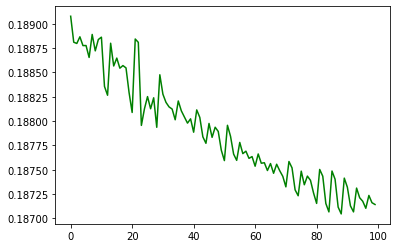

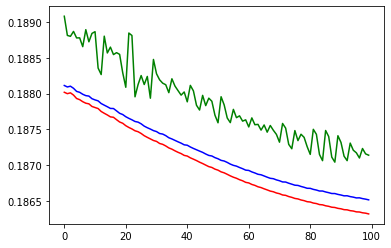

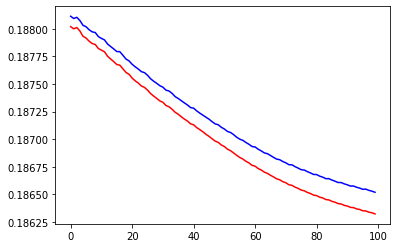

In [25]:
loss_tot = []
autoloss_validation=[]
autoloss_train = []

X = tf.constant(Re_Im_lattice_train, dtype=tf.float32)
X_val = tf.constant(Re_Im_lattice_val, dtype=tf.float32)
X_labeled = tf.constant(Re_Im_labeled, dtype=tf.float32)
y_label = tf.constant(conv_labels, dtype=tf.float32)


batch_size_train = 12 #should divide train_conf*number_T
batch_number_train = int(train_conf*number_T/batch_size_train)
batch_size_val = 12 #should divide (number_conf-train_conf)*number_T
batch_number_val = int((number_conf-train_conf)*number_T/batch_size_val)

epoch = 100

for i in range(epoch):
  #training and saving the various losses
  loss_tot.append ( train_batch(X_labeled,y_label,X,batch_number_train,batch_size_train) )
  autoloss_validation.append( conv_val_loss(X_val,batch_number_val,batch_size_val) )
  autoloss_train.append(conv_val_loss(X,batch_number_train,batch_size_train))
  #the following snippet prints the progress of the training 
  row = "["+"="*np.int(100/epoch *(i+1)) + ">"+"."*(np.int(100-100/epoch *(i+1)))+"]"
  sys.stdout.write("\r %d%% %s " %( 100/epoch *(i + 1),row))
  sys.stdout.flush()
  time.sleep(0.1)

sys.stdout.write("\n")

#plot the total loss alone
plt.plot ( loss_tot, 'g' ) 
# plt.savefig('losstot_C_semisup.pdf')

#plot the total loss along with training and validation losses for the autoencoder
plt.subplots()
plt.plot ( loss_tot, 'g' )
plt.plot(autoloss_validation,'r')
plt.plot(autoloss_train,'b')
# plt.savefig('loss_C_semisup.pdf')

#plot the training and validation losses for the autoencoder
plt.subplots()
plt.plot(autoloss_validation,'r')
plt.plot(autoloss_train,'b')
print("Total loss=",loss_tot[-1].numpy(),'autoencoder loss: train=',autoloss_train[-1].numpy(),' autoencoder loss: validation=',autoloss_validation[-1].numpy())

Text(0, 0.5, 'Encoded')

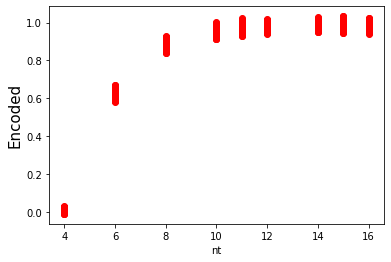

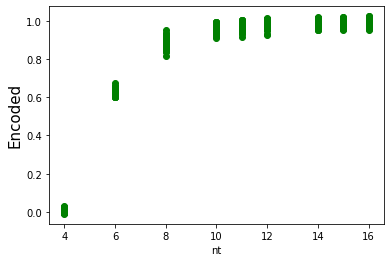

In [26]:
def encoder_evaluate(train,validation,batch_size_t,batch_number_t,batch_size_v,batch_number_v):
  #find the output of the encoder. This is done in batches to prevent running out of memory.
  out_T = []
  out_V = []

  for j in range(batch_number_t):
    out_T.append( conv_encoder(train[j*batch_size_t:(j+1)*batch_size_t]) )

  for j in range(batch_number_v):
    out_V.append( conv_encoder(val[j*batch_size_v:(j+1)*batch_size_v]) )

  return out_T, out_V

conv_encoded_train, conv_encoded_val = dajenpo(Re_Im_lattice_train, Re_Im_lattice_val, batch_size_train, batch_number_train,batch_size_val, batch_number_val)


plt.plot(y_train,conv_encoded_train,'ro')
plt.xlabel('nt')
plt.ylabel(r'Encoded',size=15)
# plt.savefig('semisupervised_T_fluct.pdf')


plt.subplots()
plt.plot(y_val,conv_encoded_val,'go')
plt.xlabel('nt')
plt.ylabel(r'Encoded',size=15)
# plt.savefig('semisupervised_V_fluct.pdf')

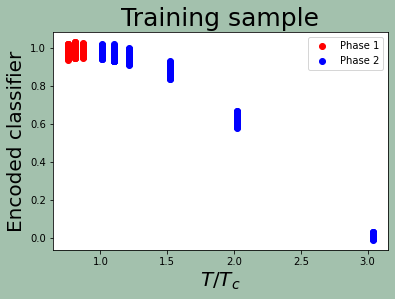

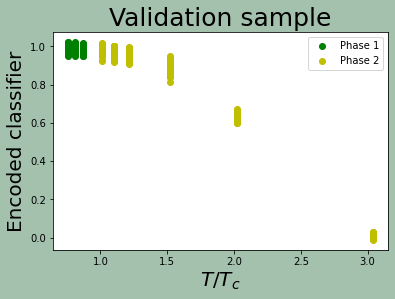

In [27]:
a_qcd = 0.0823*1/200 #MeV
T_c = 200 #MeV
y_t = conv_encoded_train
x_t = 1/T_c *1/(a_qcd*y_train)
y_v = conv_encoded_val
x_v = 1/T_c *1/(a_qcd*y_val)

#plot the figures

plt.figure(facecolor="#a3c1ad")
plt.title(r"Training sample",size=25)
# plt.plot(x_train,y_train,'ro')
plt.plot(x_t[x_t<=1],y_t[x_t<=1],'ro',label='Phase 1')
plt.plot(x_t[x_t>1],y_t[x_t>1],'bo',label='Phase 2')
plt.xlabel('$T/T_c$',size=20)
plt.ylabel(r'Encoded classifier',size=20)
plt.legend()
# plt.savefig('QCD_train.pdf',facecolor="#a3c1ad")
plt.figure(facecolor="#a3c1ad")
plt.title(r"Validation sample",size=25)
plt.plot(x_v[x_v<=1],y_v[x_v<=1],'go',label='Phase 1')
plt.plot(x_v[x_v>1],y_v[x_v>1],'yo',label='Phase 2')
# plt.plot(x_val,y_val,'go')
plt.xlabel('$T/T_c$',size=20)
plt.ylabel(r'Encoded classifier',size=20)
plt.legend()
# plt.savefig('QCD_val.pdf',facecolor="#a3c1ad")